# Initialize


In [8]:
%load_ext autoreload
%autoreload 2

#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn

import sys
sys.path.append('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders')
from AE.models import AE_0, ProgressiveAE
from AE.datasets import MNISTDigit2Dataset

from AE.depth_utils import get_KL_with_HFM_with_optimal_g
from AE.depth_utils import plot_KLs_vs_hidden_layers, datasets_dicts_comparison

#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

# if torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print("Utilizzo Apple Silicon GPU (MPS)")
# elif torch.cuda.is_available():
#     device = torch.device("cuda")
#     print("Utilizzo NVIDIA GPU (CUDA)")
# else:
#     device = torch.device("cpu")
#     print("Utilizzo la CPU")

device = torch.device("cpu")  # Fallback to CPU if no GPU is available

SEED = 42
torch.manual_seed(SEED)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



# Datasets


In [9]:

batch_size = 64

## MNIST
train_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )



## ExtendedMNIST

train_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )


## 2MNIST

dataset_2MNIST_train = MNISTDigit2Dataset(train=True, download=True, target_size=60000)
print(f"Dataset size: {len(dataset_2MNIST_train)}")
print(f"Image shape: {dataset_2MNIST_train[0][0].shape}")
print(f"Label: {dataset_2MNIST_train[0][1]}")
train_loader_2MNIST = DataLoader(dataset_2MNIST_train, batch_size=batch_size, shuffle=True)

batch_images, batch_labels = next(iter(train_loader_2MNIST))
print(f"Batch images shape: {batch_images.shape}")
print(f"Batch labels shape: {batch_labels.shape}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")

print("\n––––––––––––––––––––––––––––––––––––––––––––––––––––––\n")

dataset_2MNIST_val = MNISTDigit2Dataset(train=False, download=True, target_size=10000)
print(f"Dataset size: {len(dataset_2MNIST_train)}")
print(f"Image shape: {dataset_2MNIST_train[0][0].shape}")
print(f"Label: {dataset_2MNIST_train[0][1]}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")
val_loader_2MNIST = DataLoader(dataset_2MNIST_val, batch_size=batch_size, shuffle=True)

print(f"Batch images shape: {batch_images.shape}")
print(f"Batch labels shape: {batch_labels.shape}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")



#-------------------------------------------------------------------


datasets = ["MNIST", "EMNIST", "2MNIST"]
train_loaders = {
    "MNIST": train_loader_MNIST,
    "EMNIST": train_loader_EMNIST,
    "2MNIST": train_loader_2MNIST
}
val_loaders = {
    "MNIST": val_loader_MNIST,
    "EMNIST": val_loader_EMNIST,
    "2MNIST": val_loader_2MNIST
}


Found 5958 original samples of digit '2'
Generated 60000 augmented samples
Dataset size: 60000
Image shape: torch.Size([1, 28, 28])
Label: 2
Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])
All labels are 2: True

––––––––––––––––––––––––––––––––––––––––––––––––––––––

Found 1032 original samples of digit '2'
Generated 10000 augmented samples
Dataset size: 60000
Image shape: torch.Size([1, 28, 28])
Label: 2
All labels are 2: True
Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])
All labels are 2: True


In [ ]:


## FashionMNIST

train_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )



# Analysis

## 6 features


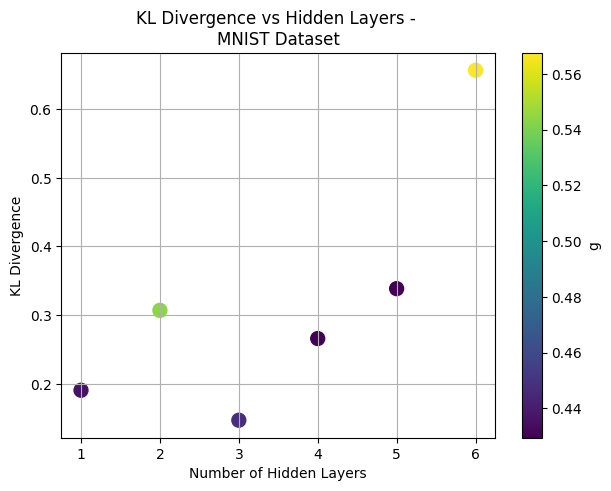

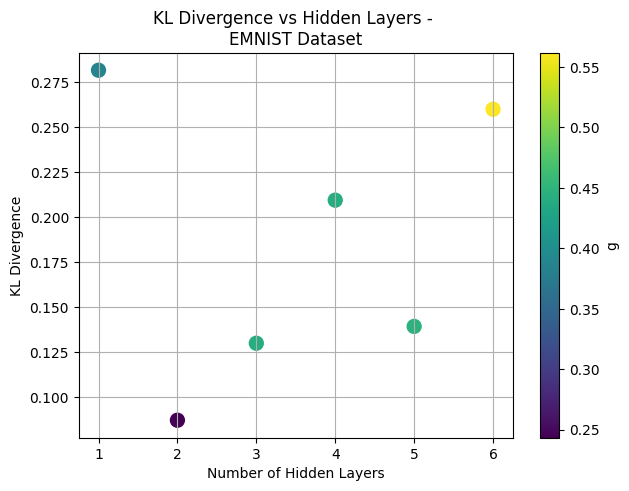

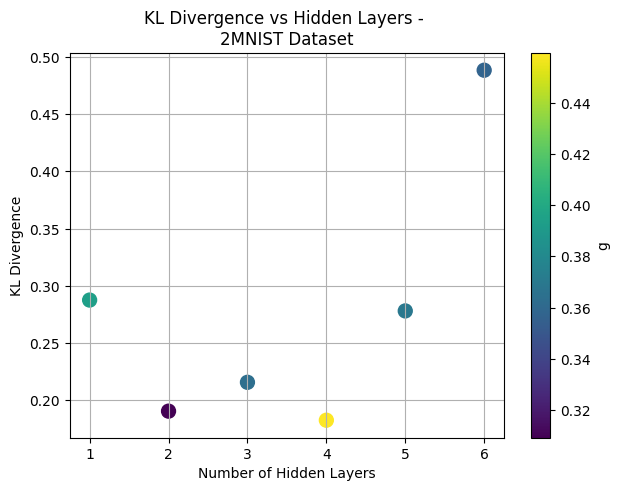

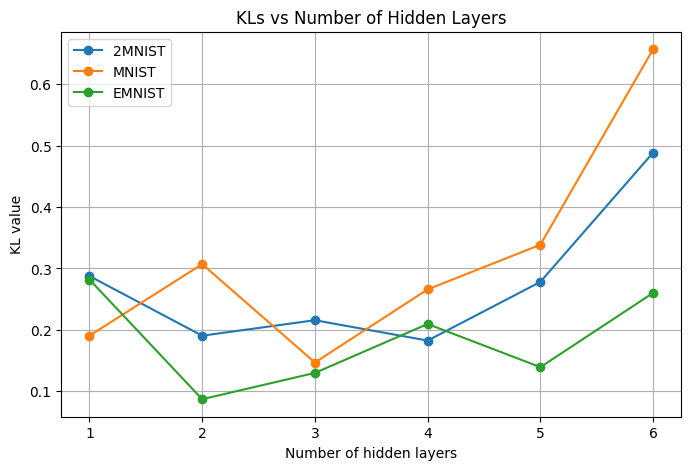

In [15]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  




for dataset in datasets:
    
    for num_hidden_layers in range(1,7):
        latent_dim = 6
        decrease_rate = 0.7
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28
        threshold_for_binarization = 0.3

        my_model = ProgressiveAE(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            num_hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))

        KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True, threshold_for_binarization=threshold_for_binarization)
        
        KLs_dict[dataset].append(KL)
        gs_dict[dataset].append(g)

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset)

datasets_dicts_comparison(KLs_dict)

## 8 features

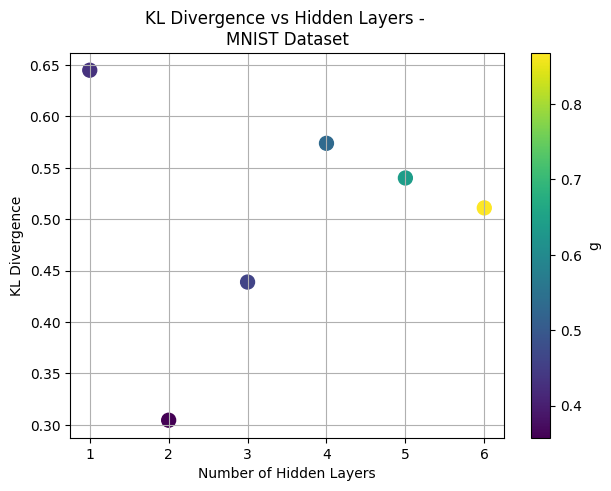

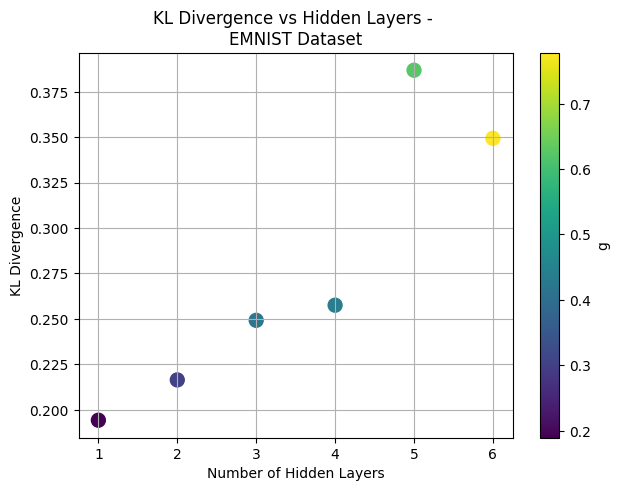

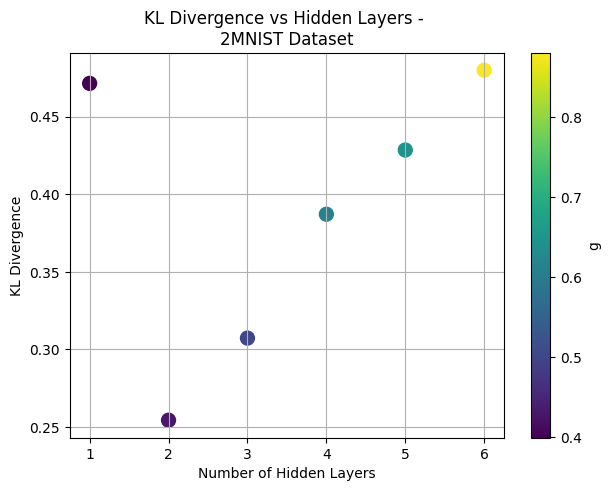

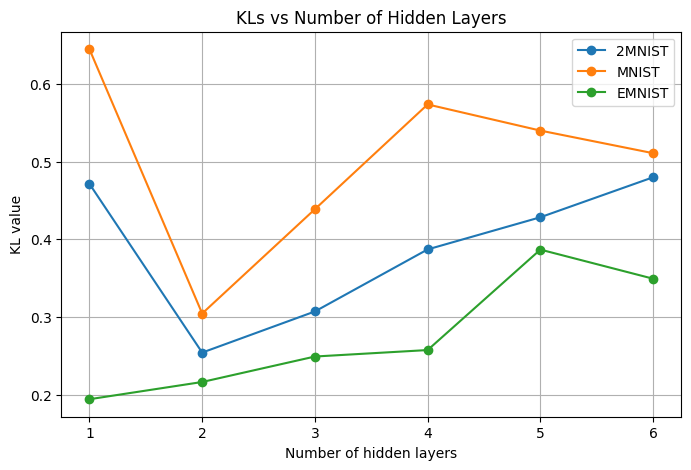

In [ ]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  




for dataset in datasets:
    
    for num_hidden_layers in range(1,7):
        latent_dim = 8
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28
        decrease_rate = 0.7,
        threshold_for_binarization = 0.5

        my_model = ProgressiveAE(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            num_hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))

        KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True, threshold_for_binarization=threshold_for_binarization)
        
        KLs_dict[dataset].append(KL)
        gs_dict[dataset].append(g)

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset)

datasets_dicts_comparison(KLs_dict)

## 10 features


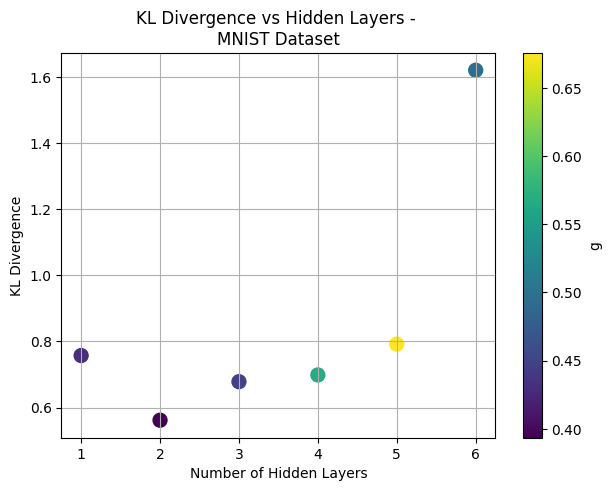

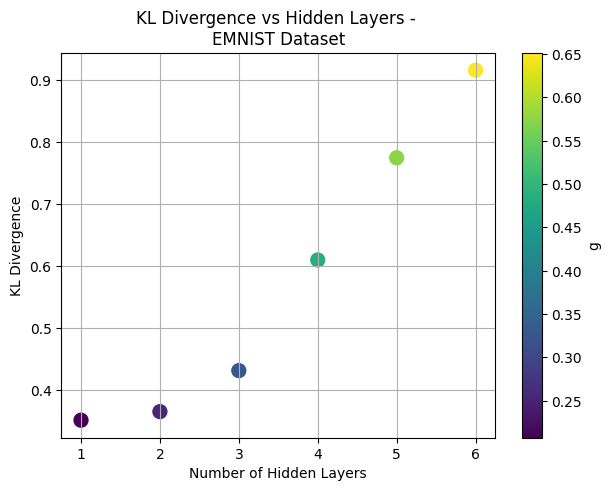

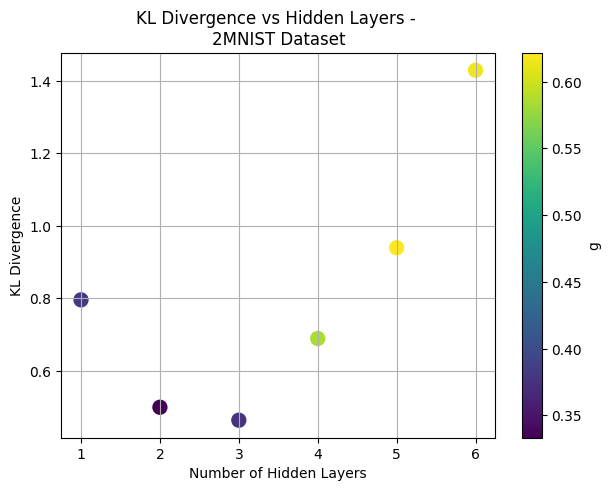

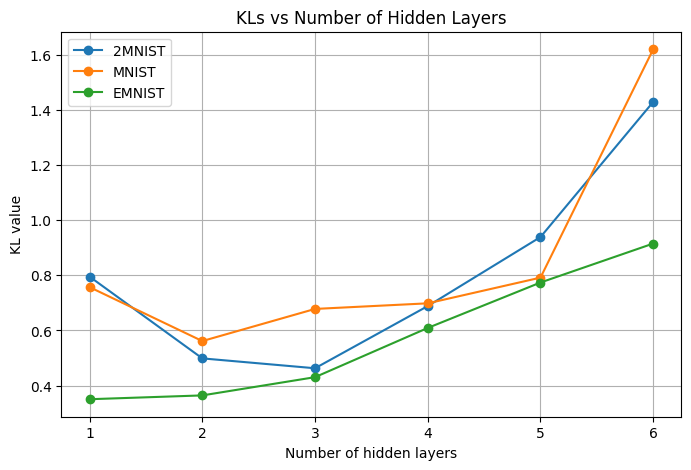

In [ ]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  




for dataset in datasets:
    
    for num_hidden_layers in range(1,7):
        latent_dim = 10
        decrease_rate = 0.7
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28
        threshold_for_binarization = 0.5

        my_model = ProgressiveAE(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            num_hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))

        KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
        
        KLs_dict[dataset].append(KL)
        gs_dict[dataset].append(g)

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, threshold_for_binarization=threshold_for_binarization)

datasets_dicts_comparison(KLs_dict)